# CNN - CIFAR10 - Data Augmentation

In [2]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


## Loading the packages

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170500096/170498071 [==============================] - 6s 0us/step


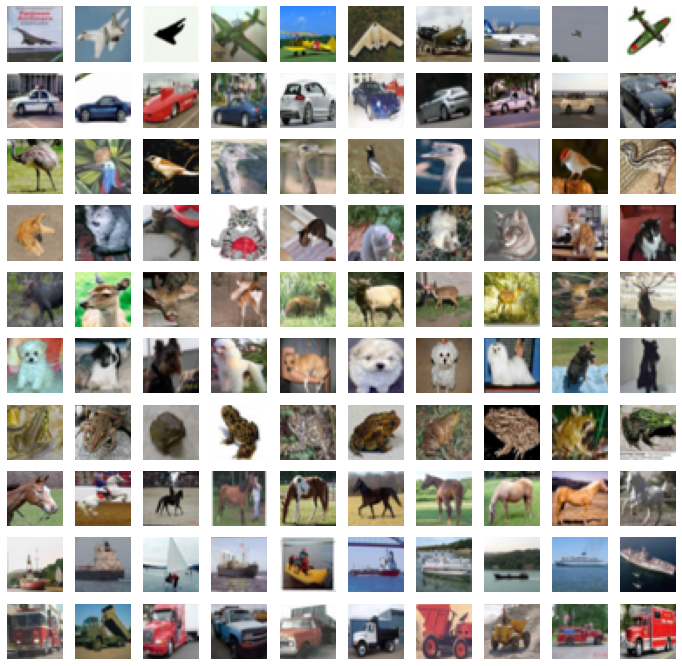

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [4]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [6]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network
The neural network will be a CNN. Follow the structure given in the exercise 1.

In [7]:
def define_model() :
  cnn = Sequential()

  cnn.add(Conv2D(32, kernel_size=(3,3), padding="same", input_shape = X_train.shape[1:]))
  cnn.add(Activation("relu"))
  cnn.add(Conv2D(32, kernel_size=(3,3), padding="same"))
  cnn.add(Activation("relu"))

  cnn.add(MaxPooling2D(2))

  cnn.add(Conv2D(32, kernel_size=(3,3), padding="same"))
  cnn.add(Activation("relu"))

  cnn.add(MaxPooling2D(2))

  cnn.add(Flatten())

  cnn.add(Dense(n_classes,activation="softmax"))

  return cnn

cnn = define_model()
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0

## Compile and train the network

When compiling the model, we need to specify the loss function, the optimizer and the metrics we want to track during the training. In Keras, we need to call the methods `compile()` and `fit()`. We will train through E epochs, using batches of size B, as specified in the exercise 1.

- The `categorical_crossentropy` loss is relevant for multiclass, single-label classification problem. Categorical is used because there are 10 classes to predict from. If there were 2 classes, we would have used `binary_crossentropy`.
- The `adam` optimizer is an improvement over SGD(Stochastic Gradient Descent). The optimizer is defining the update rule for the weights of the neurons during backpropagation gradients.

In [20]:
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
log = cnn.fit(X_train, Y_train, batch_size=128, epochs=25,verbose=1, validation_data=(X_test,Y_test))

Epoch 1/25
391/391 [==============================] - 4s 9ms/step - loss: 1.2400 - accuracy: 0.5610 - val_loss: 1.1245 - val_accuracy: 0.6074
Epoch 2/25
391/391 [==============================] - 3s 9ms/step - loss: 1.0769 - accuracy: 0.6278 - val_loss: 1.0368 - val_accuracy: 0.6431
Epoch 3/25
391/391 [==============================] - 3s 9ms/step - loss: 0.9613 - accuracy: 0.6686 - val_loss: 0.9475 - val_accuracy: 0.6698
Epoch 4/25
391/391 [==============================] - 3s 9ms/step - loss: 0.9022 - accuracy: 0.6872 - val_loss: 0.9386 - val_accuracy: 0.6744
Epoch 5/25
391/391 [==============================] - 3s 9ms/step - loss: 0.8364 - accuracy: 0.7117 - val_loss: 0.9030 - val_accuracy: 0.6886
Epoch 6/25
391/391 [==============================] - 3s 9ms/step - loss: 0.8009 - accuracy: 0.7242 - val_loss: 0.8586 - val_accuracy: 0.7055
Epoch 7/25
391/391 [==============================] - 3s 9ms/step - loss: 0.7712 - accuracy: 0.7376 - val_loss: 0.8855 - val_accuracy: 0.6971
Epoch 

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

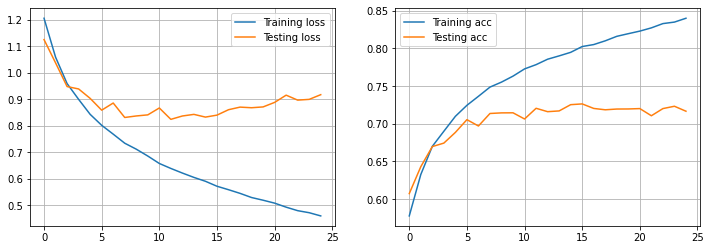

In [21]:

f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [22]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.9169848561286926
Test accuracy: 0.71670001745224


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [23]:
pred = cnn.predict_classes(X_test, verbose=0)
confusion_matrix(y_test, pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[750,  19,  48,  25,   6,   7,  11,  12,  74,  48],
       [ 13, 834,   6,  12,   1,   2,   6,   4,  31,  91],
       [ 69,   5, 581,  55,  73,  61, 104,  31,  11,  10],
       [ 25,   6,  77, 559,  47, 150,  88,  22,  12,  14],
       [ 18,   3,  92,  91, 600,  39,  89,  50,  14,   4],
       [ 13,   1,  60, 207,  27, 598,  40,  35,  10,   9],
       [  7,   4,  36,  52,  14,  20, 850,   5,   9,   3],
       [ 17,   4,  54,  44,  39,  62,  19, 743,   5,  13],
       [ 57,  31,   7,  17,   5,   8,   8,   2, 842,  23],
       [ 27,  73,   9,  15,   2,   8,   7,  15,  34, 810]])

## Data Augmentation

Overfitting can be caused by having networks with too many parameters that are trained on too few samples. Through training, the model learns *by hart* and generalizes poorly.

**Data augmentation** takes the approach of generating artificially more training data from existing training samples. For images, data augmentation is performed via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will not see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ```ImageDataGenerator``` instance.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range=5, shear_range=0.05, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.05)

batches = generator.flow(X_train, Y_train, batch_size=128)
val_batches = generator.flow(X_test, Y_test, batch_size=128)

Don't forget to reset your network (by defining it again). You need then to compile the network and train it. The call to the `fit()` function has to be replaced by a call to `fit_generator()` and using the data flow defined above. 

In [12]:
cnn = define_model()
cnn.summary()

cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])
log = cnn.fit(batches, steps_per_epoch=X_train.shape[0]//128, epochs=25, validation_data=val_batches, validation_steps=X_test.shape[0]//128)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 32)       

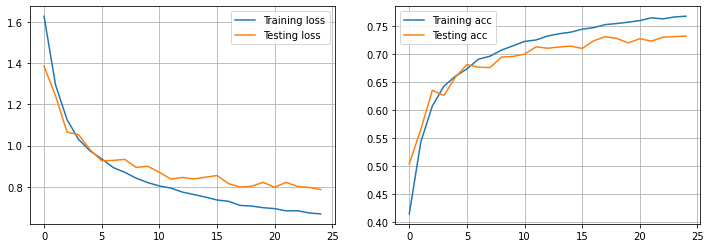

In [14]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [30]:
loss_test, metric_test = cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8561450242996216
Test accuracy: 0.714900016784668


### Table of results

Describe your data augmentation strategies here.


| DA | Parameters |
|-----|--------------------------|
|  No DA | - |
|  DA v1 | rotation_range=10, shear_range=0.08, width_shift_range=0.08, height_shift_range=0.08, zoom_range=0.08 |
|  DA v2 | rotation_range=20, shear_range=0.10, width_shift_range=0.10, height_shift_range=0.10, zoom_range=0.10 | 
| DA v3 | rotation_range=30, shear_range=0.15, width_shift_range=0.15, height_shift_range=0.15, zoom_range=0.20 |
| DA v4 | rotation_range=05, shear_range=0.05, width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.05 |

| CNN | Architecture description | Acc. train | Acc. test |
|-----|--------------------------|------------|-----------|
|  No DA | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.848  | 0.717 |
|  With DA v1 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.708  | 0.702 |
|  With DA v2 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.720  | 0.700 |
| With DA v3 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.654 | 0.632 |
| With DA v4 | CONV(32F,same)-RELU-CONV(32F,same)-RELU-MAXP(2)-CONV(32F,same)-RELU-MAXP(2)-DENSE | 0.776| 0.733 |

# Visualisation of activation in each layer

In [57]:
from tensorflow.keras import models 
from math import sqrt, ceil

def plot_activation(model, layer, image):
  # Activation
  activation_model = models.Model(inputs=model.input, outputs=model.layers[layer].output)
  layer_activation = activation_model.predict(image) # activation of the [image] applied to the [layer]'s layer 

  # Display
  length = layer_activation.shape[-1]   # number of filters in layer
  size_plot = ceil(sqrt(length))        # height and width of the subplot

  plt.imshow(image.reshape(*X_train.shape[1:]))

  fig, axes = plt.subplots(size_plot,size_plot, figsize=(10,10))
  axes = axes.flatten()

  for idx in range(0, length):
    axes[idx].matshow(layer_activation[0, :, :, idx])
    axes[idx].set_title(f"filter n°{idx}")

  for idx in range(0, size_plot*size_plot):
    axes[idx].axis('off')

  fig.tight_layout()
  plt.show()


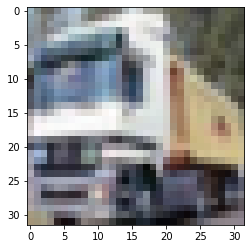

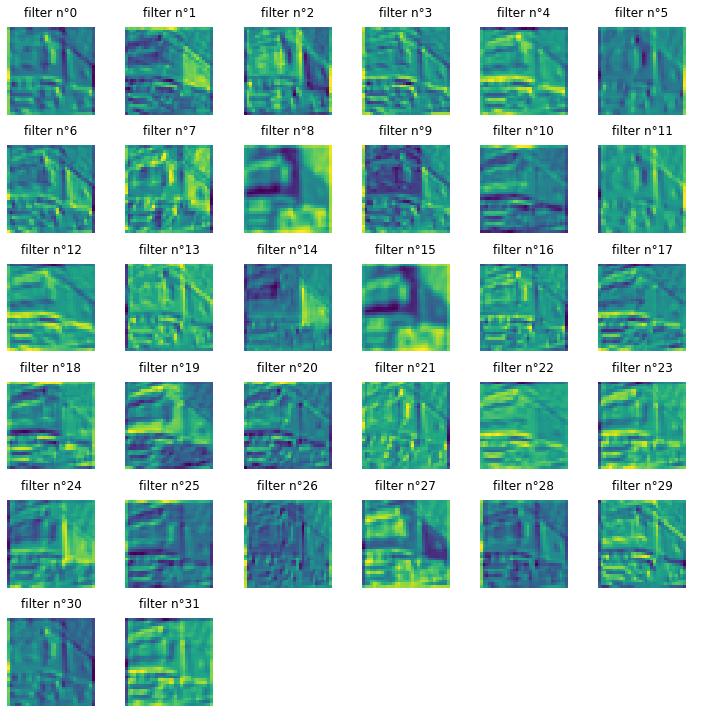

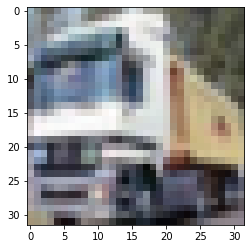

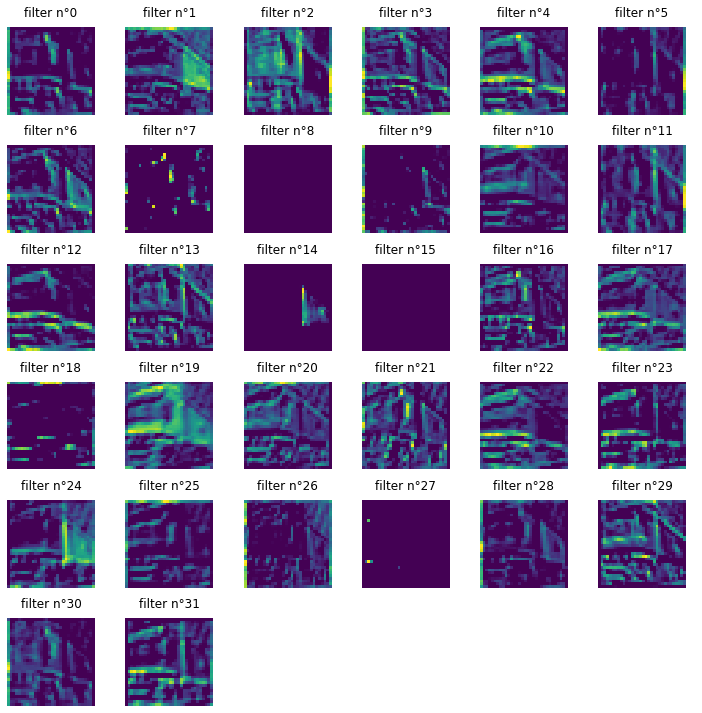

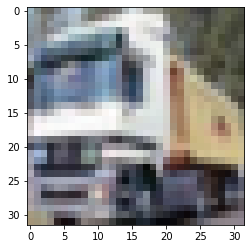

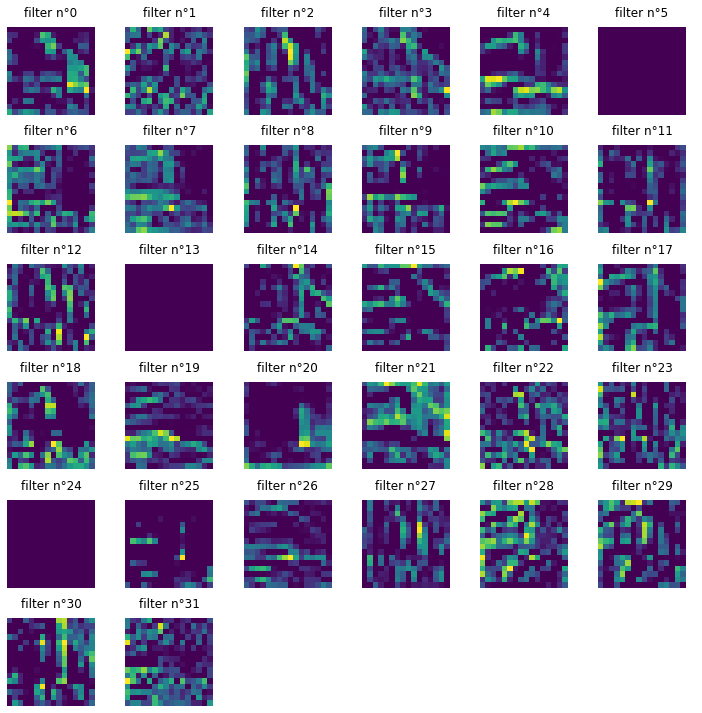

In [59]:
test_img = X_train[1].reshape(1,*X_train.shape[1:])

plot_activation(cnn, 0, test_img) # CONV
plot_activation(cnn, 1, test_img) # RELU
plot_activation(cnn, 4, test_img) # MAXPOOL
